<a href="https://colab.research.google.com/github/AlexMont/GestureClassifier/blob/master/GesturesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GESTURE SIGN CLASSIFIER**
In this project, a classifier is built and the objective is to determine if a gesture is positive or negative.

For this purpose, I used the ResNet152 Convolutional Neural Network model and the fastai framework that is built upon PyTorch.

The dataset was obtained from Google Images. 

Before starting, due to an incompatibility problem with the current Pytorch installation and a method used to upsample images, a downgrade is needed.
In further improvements I will properly fix this problem. 

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 2.8MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


**Mounting the data:**

First step is to mount the dataset in the Drive. To do that, run the code below, click on the link, copy and paste the permission link. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Preparing the Data:**

This first lines of code ensure that any edits to libraries are reloaded  automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Then, import all libraries and packages that will be used.


In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from pathlib import Path

Here, I specify the root directory and the base directory that are the path for the data.

Also, I set the batch size (bs) and normalize the size of the images.

In [5]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'Data/'
base_dir_test = root_dir + 'testData'

bs = 32
size = 224

path = Path(base_dir)
path_test = Path(base_dir_test)


Then, I just check the path and its contents.

In [6]:
path.ls()

[PosixPath('/content/drive/My Drive/Data/THUMBSUP'),
 PosixPath('/content/drive/My Drive/Data/THUMBSDOWN'),
 PosixPath('/content/drive/My Drive/Data/models')]

In [7]:
path_test.ls()

[PosixPath('/content/drive/My Drive/testData/hangloose.jpeg'),
 PosixPath('/content/drive/My Drive/testData/loser.jpeg'),
 PosixPath('/content/drive/My Drive/testData/loveu.jpeg'),
 PosixPath('/content/drive/My Drive/testData/negative.jpeg'),
 PosixPath('/content/drive/My Drive/testData/peacenlove.jpeg'),
 PosixPath('/content/drive/My Drive/testData/positive.jpeg'),
 PosixPath('/content/drive/My Drive/testData/kiss.jpeg'),
 PosixPath('/content/drive/My Drive/testData/luck.jpg'),
 PosixPath('/content/drive/My Drive/testData/no.jpg'),
 PosixPath('/content/drive/My Drive/testData/power.jpg'),
 PosixPath('/content/drive/My Drive/testData/notluck.jpg'),
 PosixPath('/content/drive/My Drive/testData/greeting.jpeg'),
 PosixPath('/content/drive/My Drive/testData/banana.jpeg'),
 PosixPath('/content/drive/My Drive/testData/horn.jpeg'),
 PosixPath('/content/drive/My Drive/testData/notinterested.jpg'),
 PosixPath('/content/drive/My Drive/testData/ok.jpg'),
 PosixPath('/content/drive/My Drive/testDa

In the codes below, I specify the two classes: 

THUMBSUP for positive gestures and THUMBSDOWN for negative gestures.

Also, I check if the images of the training and validation datasets have any problem.

In [9]:
classes = ['THUMBSUP', 'THUMBSDOWN']

for c in classes:    
    verify_images(path/c, delete=True, max_size=500)    
print ("There are", len(classes), "classes:\n", classes)  

There are 2 classes:
 ['THUMBSUP', 'THUMBSDOWN']


Now, the image data bunch is created.

The function creates two datasets: Train and Validation

Of all images, 10% are separated for the validation dataset and 90% for the training dataset. I chose this configuration because I need more images for the training process.

I applied some data augmentation, like rotation, zooming, flipping and some others.

Also, the pixel values are normalized.

In [11]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.1,
        ds_tfms=get_transforms(do_flip =True,flip_vert=False, max_rotate=25.0, max_lighting=0.1, max_zoom=1.05, max_warp=0), size=size, bs=bs).normalize(imagenet_stats)

data.classes

['THUMBSDOWN', 'THUMBSUP']

Let's see some examples of the data buch created, with its labels:

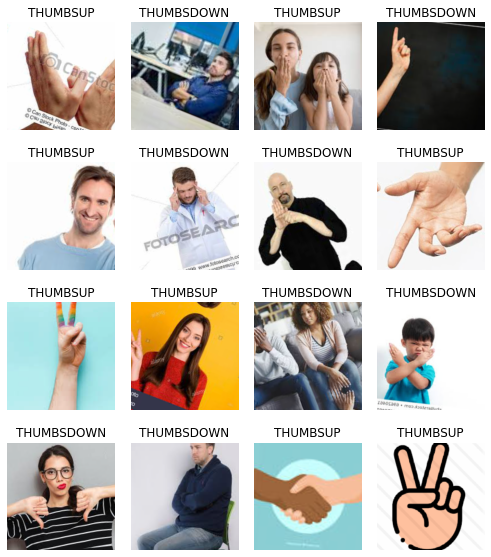

In [12]:
data.show_batch(rows=4, figsize=(7,8))

Just to check the total number of images.

In [13]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 594 training images and 65 validation images.


**Training**

In the first step of the training part, I specified the learner, or the Neural Network model used and the metrics to measure the results of training process.

The model is ResNet152 and its architecture can be seen below.



In [14]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

Now, the training starts.

With the command *learn.fit_one_cycle*, the learning rate is dynamic and adapts to the data. I train the model for 20 epochs and then, save the parameters or weights.

epoch,train_loss,valid_loss,accuracy,time
0,1.186028,0.489107,0.769231,00:32
1,0.986232,0.581275,0.753846,00:24
2,0.969295,0.580858,0.800000,00:24
3,0.820706,0.351149,0.876923,00:24
4,0.744487,0.588633,0.784615,00:24
5,0.669266,0.407753,0.815385,00:24
6,0.571942,0.339812,0.861538,00:24
7,0.491430,0.354395,0.830769,00:24
8,0.421888,0.302881,0.861538,00:24
9,0.383202,0.231390,0.876923,00:24


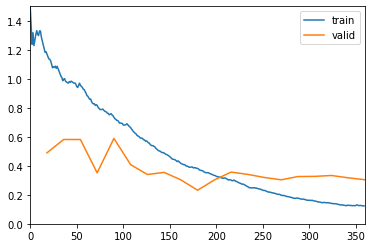

In [16]:
learn.fit_one_cycle(20, callbacks=[ShowGraph(learn)])

In [17]:
learn.save('stage-1')

Now, I can see the results of the first stage of the process. So, we check the main losses over the validation dataset.
I define a interpreter and plot the top losses.

The first class is the one predicted, the second is the actual class. Then, the loss value and the probability of the image to be of the actual class.

I also plot a Confusion Matrix, which is a good visual metric to validate the results.

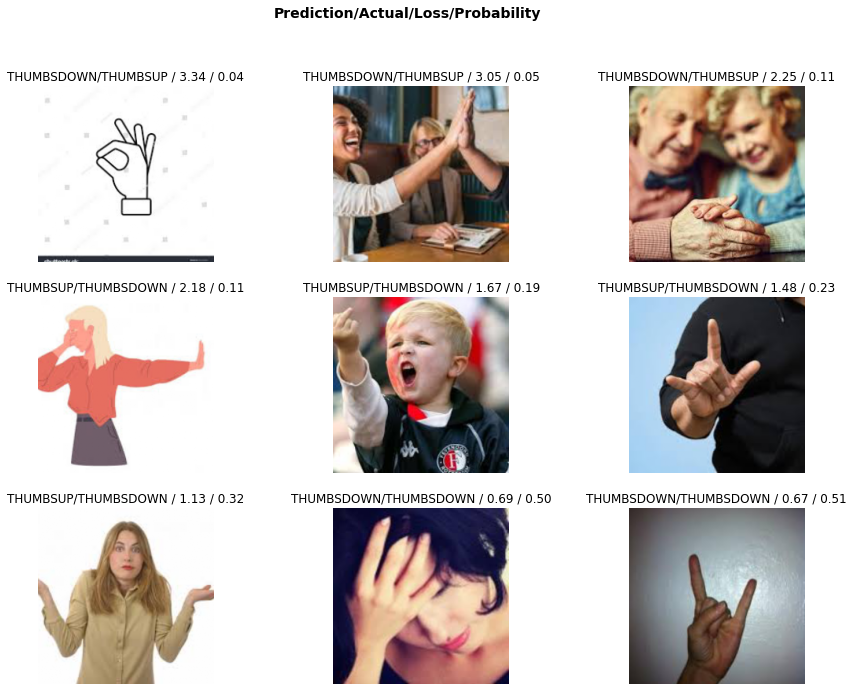

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

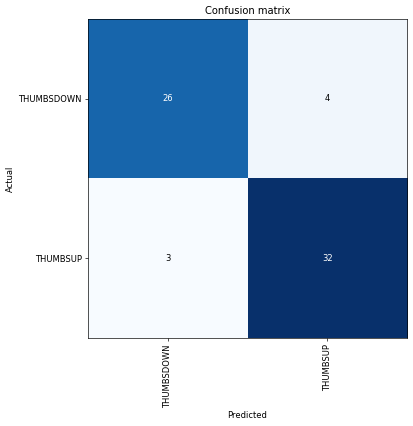

In [19]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

**Fine-Tunning**

In this step, I try to get better results by fine-tunning the classifier.

This is done firstly unfreezing the first layers of the ResNet152.

Now, I train again using all layers of the model.
In the first training process, the initial layers were freezed and the wieghts used were the ones where this model was previously trained.

In [20]:
learn.unfreeze()

Now, I find the best range of learning rates to minimize the loss at training time with the method *learn.lr_find()*.

With this technique, the first layers are trained with a lower learning rate and last layers with a higher learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


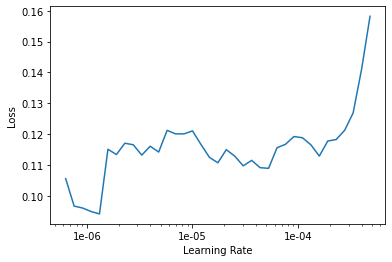

In [21]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.130822,0.318483,0.892308,00:33
1,0.107820,0.324430,0.892308,00:33
2,0.097965,0.311578,0.892308,00:33
3,0.106216,0.289413,0.892308,00:33
4,0.099224,0.282631,0.892308,00:33
5,0.097358,0.310991,0.861538,00:33
6,0.092998,0.309277,0.861538,00:33
7,0.095964,0.291689,0.892308,00:33
8,0.087866,0.299671,0.892308,00:33
9,0.086990,0.295841,0.892308,00:33


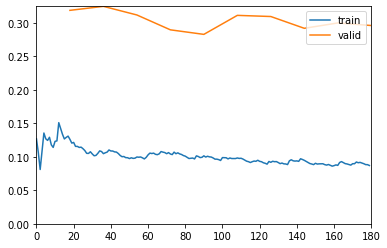

In [22]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn)])

In [23]:
learn.save('stage-2')

In [24]:
learn.load('stage-2');

Again we validate the results.

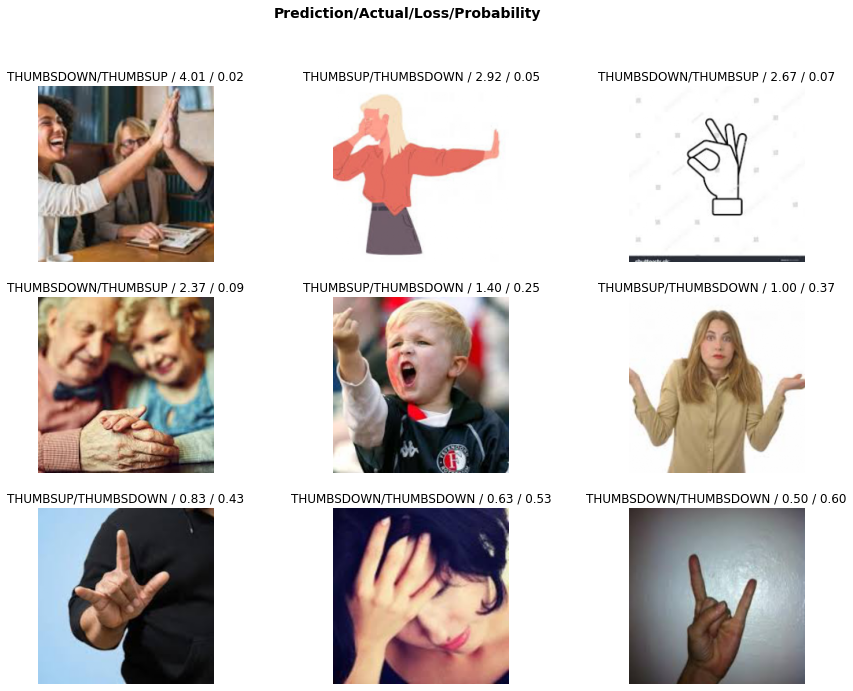

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

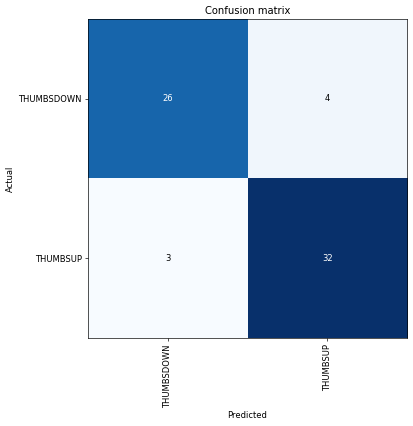

In [26]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

**Prediction**

Now, I make predictions with the trained model to 
check if it was able to learn and generalize well for new images.

The test dataset was made by me with the collaboration of some friends.

In [32]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (594 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
THUMBSUP,THUMBSUP,THUMBSUP,THUMBSUP,THUMBSUP
Path: /content/drive/My Drive/Data;

Valid: LabelList (65 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
THUMBSUP,THUMBSUP,THUMBSDOWN,THUMBSDOWN,THUMBSDOWN
Path: /content/drive/My Drive/Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d

/content/drive/My Drive/testData/hangloose.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/loser.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/loveu.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/negative.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/peacenlove.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/positive.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/kiss.jpeg --> It is a THUMBSUP
/content/drive/My Drive/testData/luck.jpg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/no.jpg --> It is a THUMBSUP
/content/drive/My Drive/testData/power.jpg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/notluck.jpg --> It is a THUMBSUP
/content/drive/My Drive/testData/greeting.jpeg --> It is a THUMBSUP
/content/drive/My Drive/testData/banana.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/horn.jpeg --> It is a THUMBSDOWN
/content/drive/My Drive/testData/notinterested.jpg --> It i

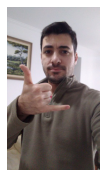

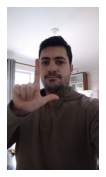

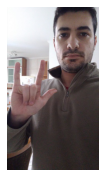

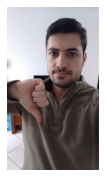

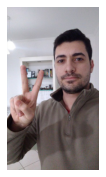

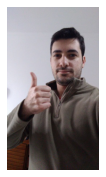

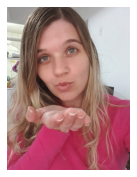

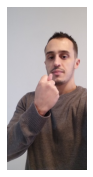

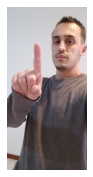

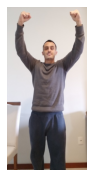

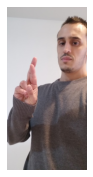

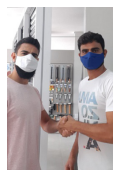

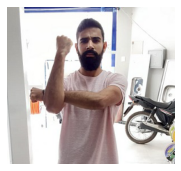

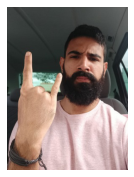

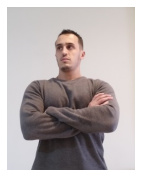

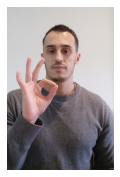

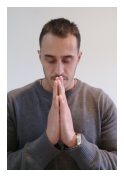

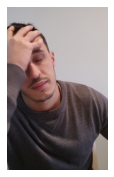

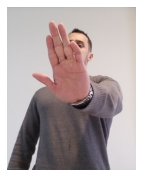

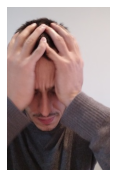

In [33]:
fnames = get_image_files(path_test)

for i in range(0,len(fnames)):
  img = open_image(fnames[i])  
  pred_class,pred_idx,outputs = learn.predict(img)
  img.show()
  print (fnames[i], "--> It is a", pred_class)

**Conclusion**

To conclude, I would like to highlight some points.



*   The datset is very complex and because of that, is necessary a complex model to process it.
*   This dataset was created by capturing Google Images and to have a reasonable amount of them, I mixed photos of people doing gestures and just a hand showing some gesture.
*   To be a more realistic classifier, maybe just pictures with people doing gestures should have been used. The problem is that the dataset would be even smaller than this one, and the model wouldn't be able to learn well.
*   We can see from the graphs of training and validation that at some point, the model just cannot learn anymore. The validation loss stops decreasing while the training loss keeps going down. This underfitting scenario may be caused by the complexity of the dataset. In situations like this, thousands of images are necessary for the model to learn and here we just have a few hundreds. The dataset doesn't have enough exmples. 
*   We can conclude also, that the model cannot generalize well, because it labeled correctly only about 50% of the test images, while on the validation dataset it had an accuracy of about 89%. 
*   To summarize, this is a real nice challenge and an interesting problem to make a deeper study, varying the learner, the kind of algorithms, the amount of data and any hyperparameter to get the best results.


